In [1]:
from pathlib import Path
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from functions import get_zone, load_360_data, get_progressive_actions, zone_polygon, plot_team_zone_shares, calc_width, calc_directness, calc_tempo, calc_possession_time
import seaborn as sns

### Features to use

Main tactical features to use:
- Width offensivly ✅
Average distance from center-line (goal-to-goal) where progressive actions end. 
- Directness ✅
Relationship of progressive actions to non progressive actions
- Tempo ✅
Velocity of ball, how fast do actions happen?
- Pass length

- Restförsvar ?
- Fasta situationer ?
- Press, triggers (defensiva aktioner i offensiv planhalva) (tid för bollvinst)
- Höjd på backlinje
- Antal progressiva passningar

- Bollhastighet
- Final third entries

### Game State:
- Which zone are we in?
- Distance to goal?
- Angle to goal?
- Opponents near?
- How many opponants near?
- Score?
-  Red cards?

### Tactics: 


In [2]:
actions=("Pass", "Carry", "Dribble")
action_types_exclude = ["Throw-in", "Corner", "Free Kick", "Kick-off", "Goal Kick"]
df = load_360_data(actions, three_sixty_only=True)

print("data loaded")

#is_dead_ball_action = df["pass_type"].isin(action_types_exclude)


actions = get_progressive_actions(df=df)
prog_passes = actions[actions["is_progressive"] == False]



Loading events: 100%|██████████| 326/326 [00:17<00:00, 19.10it/s]


data loaded


In [3]:
PRESS_EVENTS = {
    "Pressure",
    "Interception",
    "Duel",
    "50/50",
    "Block",
    "Ball Recovery",
    "Foul Committed",
    # optional:
    "Dribbled Past",
}
def calc_pressing_intensity(df_all_events: pd.DataFrame) -> pd.DataFrame:
    """
    Pressing intensity = number of pressing actions while defending
    per minute of opponent possession.

    Returns columns:
      match_id, team_id, n_press_actions, opp_possession_minutes, press_intensity
    """
    df = df_all_events.copy()

    # regular play only (recommended for stability)
    df = df[df["play_pattern"].fillna("Regular Play") == "Regular Play"].copy()

    # pressing actions
    press = df[df["type"].isin(PRESS_EVENTS)].copy()

    # only when opponent owns the possession
    press = press[press["possession_team_id"].notna()].copy()
    press = press[press["possession_team_id"] != press["team_id"]].copy()

    grp = ["match_id", "team_id"]
    counts = press.groupby(grp).size().reset_index(name="n_press_actions")

    # opponent possession minutes = (match total - own possession)
    poss = calc_possession_time(df, match=True)  # match_id, team_id, possession_seconds
    poss["opp_possession_seconds"] = (
        poss.groupby("match_id")["possession_seconds"].transform("sum") - poss["possession_seconds"]
    )
    poss["opp_possession_minutes"] = poss["opp_possession_seconds"] / 60.0

    out = counts.merge(poss[["match_id", "team_id", "opp_possession_minutes"]], on=grp, how="left")
    out["press_intensity"] = out["n_press_actions"] / out["opp_possession_minutes"].replace(0, np.nan)
    return out

def calc_pressing_height(
    df_all_events: pd.DataFrame,
    high_line_x: float = 60.0,
) -> pd.DataFrame:
    """
    Pressing height = share of pressing actions that occur high up the pitch.

    high_line_x: threshold in StatsBomb x-coordinates (0..120). Opponent half starts at 60.

    Returns columns:
      match_id, team_id, n_press_actions, n_high, press_height
    """
    df = df_all_events.copy()

    # regular play only
    df = df[df["play_pattern"].fillna("Regular Play") == "Regular Play"].copy()

    press = df[df["type"].isin(PRESS_EVENTS)].copy()

    # only when defending
    press = press[press["possession_team_id"].notna()].copy()
    press = press[press["possession_team_id"] != press["team_id"]].copy()

    # require x for height classification
    press = press[press["x"].notna()].copy()

    grp = ["match_id", "team_id"]
    press["is_high"] = press["x"] >= high_line_x

    agg = (
        press.groupby(grp)
             .agg(
                 n_press_actions=("is_high", "size"),
                 n_high=("is_high", "sum"),
             )
             .reset_index()
    )
    agg["press_height"] = agg["n_high"] / agg["n_press_actions"].replace(0, np.nan)
    return agg


In [4]:

assert "is_progressive" in prog_passes.columns
# 1) compute "directness" = progressive share per match/team
press_intensity = calc_pressing_intensity(df)
press_height    = calc_pressing_height(df)


most_press = press_intensity.sort_values("press_intensity", ascending=False).iloc[0]
least_press = press_intensity.sort_values("press_intensity", ascending=True).iloc[0]

print("Most pressing intensity:\n", most_press, "\n")
print("Least pressing intensity:\n", least_press, "\n")


most_high_press = press_height.sort_values("press_height", ascending=False).iloc[0]
least_high_press = press_height.sort_values("press_height", ascending=True).iloc[0]

print("Highest press:\n", most_high_press, "\n")
print("Lowest press:\n", least_high_press, "\n")


Most pressing intensity:
 match_id                  3.941018e+06
team_id                   7.720000e+02
n_press_actions           6.300000e+01
opp_possession_minutes    3.927007e+00
press_intensity           1.604275e+01
Name: 566, dtype: float64 

Least pressing intensity:
 match_id                  3.938645e+06
team_id                   7.820000e+02
n_press_actions           4.000000e+01
opp_possession_minutes    5.636418e+01
press_intensity           7.096705e-01
Name: 558, dtype: float64 

Highest press:
 match_id           3.893827e+06
team_id            8.510000e+02
n_press_actions    4.900000e+01
n_high             4.400000e+01
press_height       8.979592e-01
Name: 372, dtype: float64 

Lowest press:
 match_id           3.893827e+06
team_id            1.676900e+04
n_press_actions    2.350000e+02
n_high             1.900000e+01
press_height       8.085106e-02
Name: 373, dtype: float64 



In [5]:
def plot_pressing_intensity_curve(df, row, max_opp_poss_min=15):
    sub = df[
        (df["match_id"] == row["match_id"]) &
        (df["possession_team_id"] != row["team_id"])
    ].copy()

    sub["t"] = pd.to_timedelta(sub["timestamp"])
    sub = sub.sort_values("t")

    # opponent possession time
    sub["t_prev"] = sub["t"].shift(1)
    same_poss = sub["possession"] == sub["possession"].shift(1)
    dt = (sub["t"] - sub["t_prev"]).dt.total_seconds().clip(lower=0)
    sub["opp_poss_dt"] = np.where(same_poss, dt, 0.0)
    sub["cum_opp_poss"] = sub["opp_poss_dt"].cumsum()

    # pressing actions
    sub["is_press"] = sub["type"].isin(PRESS_EVENTS).astype(int)
    sub["cum_press"] = sub["is_press"].cumsum()

    sub = sub[sub["cum_opp_poss"] <= max_opp_poss_min * 60]

    plt.plot(sub["cum_opp_poss"] / 60, sub["cum_press"], lw=2)
    plt.xlabel("Opponent possession time (minutes)")
    plt.ylabel("Cumulative pressing actions")
    plt.title(f"Pressing intensity – match {int(row['match_id'])}")
    plt.tight_layout()
    plt.show()
def plot_pressing_height_distribution(df, row):
    press = df[
        (df["match_id"] == row["match_id"]) &
        (df["team_id"] == row["team_id"]) &
        (df["possession_team_id"] != row["team_id"]) &
        (df["type"].isin(PRESS_EVENTS)) &
        (df["x"].notna())
    ]

    plt.hist(press["x"], bins=30, density=True)
    plt.axvline(60, color="k", linestyle="--", label="Opponent half")
    plt.xlabel("x-position")
    plt.ylabel("Density")
    plt.title(f"Pressing height – match {int(row['match_id'])}")
    plt.legend()
    plt.tight_layout()
    plt.show()


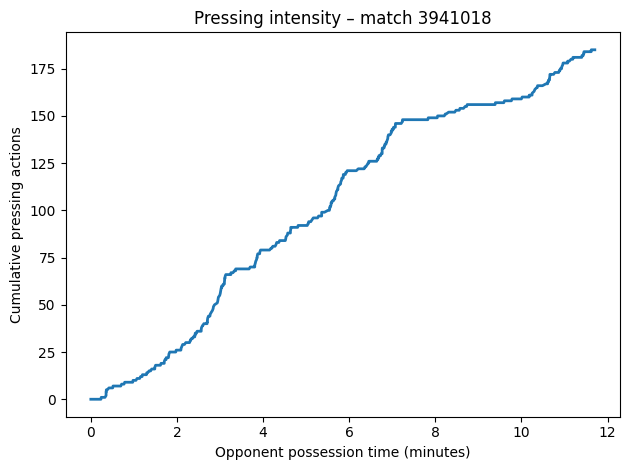

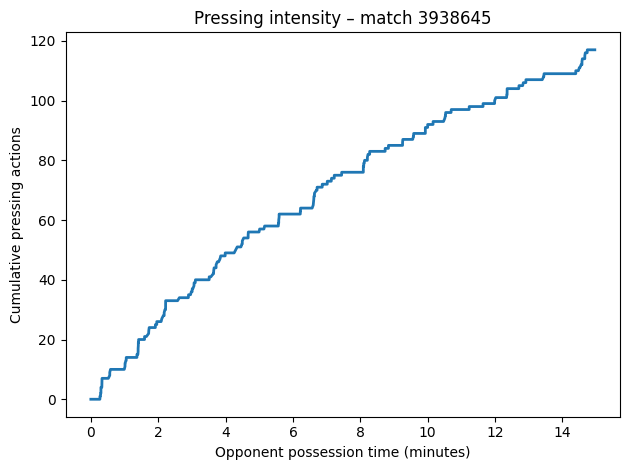

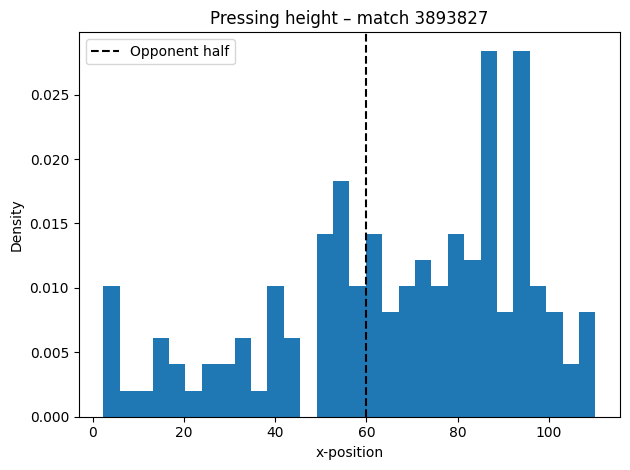

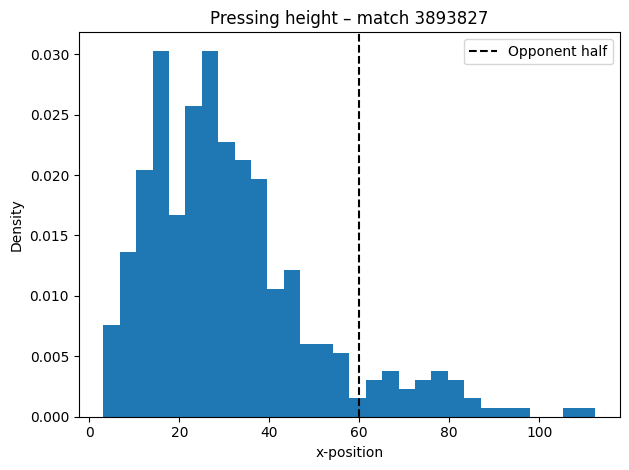

In [6]:
plot_pressing_intensity_curve(df, most_press)
plot_pressing_intensity_curve(df, least_press)
plot_pressing_height_distribution(df, most_high_press)
plot_pressing_height_distribution(df, least_high_press)
